# Demo some of the functionality of lumos-ncpt-tools

### 1) Load up some data! 
- Instantiate a NCPT class object with data from one test battery
    - The demo data is all data from NCPT battery 26
- Display some summary info on the dataset and subtests

### 2) Process and plot the scores 
- Filter out outlier raw scores
- Plot the raw score distributions before and after outlier removal
- Lookup normalized scores using the demographics-reweighted rank INT method
    - Plot the normalized scores and the Grand Index (composite score)
- Plot the Grand Index vs. age

### 3) Miscellaneous 
- Show the meaning of the numeric education levels 
- Filter out participants who did not complete the test battery

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lumos_ncpt_tools.ncpt import NCPT
from lumos_ncpt_tools.utils import load_data

## 1) Load up some data

In [2]:
# Load all of the data from one NCPT battery (demo_data.csv = battery 26)
data_directory = './'
data_fn = 'demo_data.csv'
df = load_data(data_directory, data_fn)

# Instantiate a NCPT object, display some basic info
ncpt = NCPT(df)
del df
ncpt.report_stats()
ncpt.get_subtest_info()
ncpt.df.head(10)

Data summary
------------
N users: 2400
N tests: 2400
N subtests: 23689
DataFrame columns: ['user_id', 'age', 'gender', 'education_level', 'country', 'test_run_id', 'battery_id', 'specific_subtest_id', 'raw_score', 'rank_INT_normed_score', 'grand_index']

Subtest information
-------------------
Subtest ID 27: Divided visual attention, v1, N scores = 2040
Subtest ID 28: Forward memory span, v1, N scores = 2218
Subtest ID 29: Arithmetic reasoning, v1, N scores = 2272
Subtest ID 30: Grammatical reasoning, v1, N scores = 2091
Subtest ID 32: Go/no-go, v2, N scores = 2026
Subtest ID 33: Reverse memory span, v1, N scores = 2121
Subtest ID 36: Verbal list learning, v1, N scores = 2400
Subtest ID 37: Delayed verbal list learning, v1, N scores = 1905
Subtest ID 38: Digit symbol coding, v1, N scores = 1995
Subtest ID 39: Trail making part A, v1, N scores = 2326
Subtest ID 40: Trail making part B, v1, N scores = 2295



,user_id,age,gender,education_level,country,test_run_id,battery_id,specific_subtest_id,raw_score,rank_INT_normed_score,grand_index
0,22,64.0,m,6.0,US,870660,26,36,6.0,74.538593,81.741969
1,22,64.0,m,6.0,US,870660,26,39,24.0,97.004916,81.741969
2,22,64.0,m,6.0,US,870660,26,40,38.0,99.313917,81.741969
3,22,64.0,m,6.0,US,870660,26,29,17.0,108.619013,81.741969
4,22,64.0,m,6.0,US,870660,26,28,4.0,81.084936,81.741969
5,22,64.0,m,6.0,US,870660,26,33,4.0,87.577690,81.741969
6,22,64.0,m,6.0,US,870660,26,30,9.0,103.617620,81.741969
7,22,64.0,m,6.0,US,870660,26,27,7.0,83.386703,81.741969
8,22,64.0,m,6.0,US,870660,26,32,628.0,73.831362,81.741969
9,22,64.0,m,6.0,US,870660,26,38,36.0,88.305098,81.741969


## 2) Process and plot the scores

### Check for outliers

Subtest ID 33: N outliers = 1


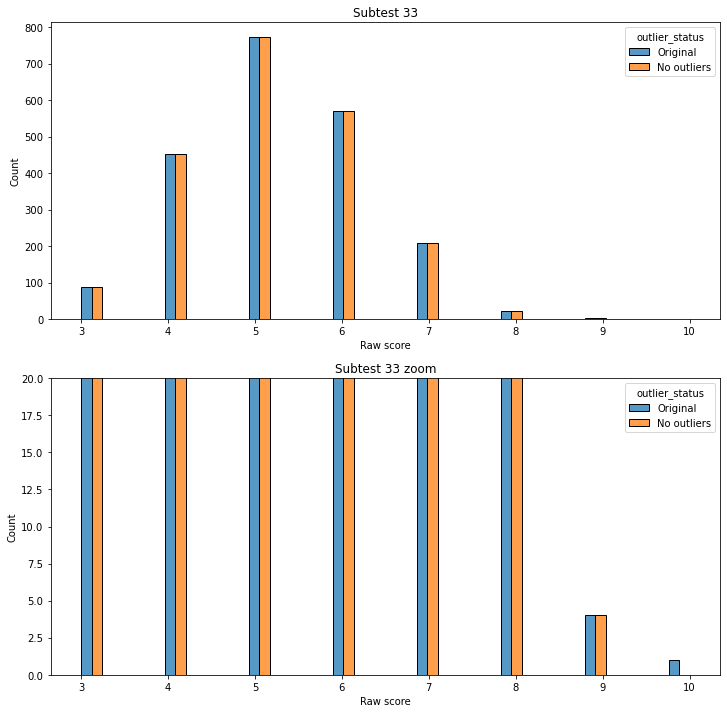

In [11]:
# Remove outlier raw scores using the median absolute deviation (MAD) method
# Note: Depending on the intended application, this may or may not be a sensible thing to do.
outlier_threshold = 5 # fairly conservative threshold
outlier_method = 'MAD'
n_bins = 10
outlier_subtests = [33] # Reverse memory span v1
zoom_ylim = [0, 20]
filt_df = ncpt.filter_outliers_by_subtest('raw_score', outlier_threshold, 
                                          outlier_subtests, method=outlier_method)

# Plot the raw score distributions before and after outlier removal
for sub in outlier_subtests:
    orig_sub_df = ncpt.df.query('specific_subtest_id == @sub')
    orig_sub_df = orig_sub_df.assign(outlier_status='Original')
    filt_sub_df = filt_df.query('specific_subtest_id == @sub')
    filt_sub_df = filt_sub_df.assign(outlier_status='No outliers')
    plot_df = pd.concat([orig_sub_df, filt_sub_df])
    plot_df.reset_index(drop=True, inplace=True)
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    for ax_ind, ax in enumerate(axes):
        sns.histplot(plot_df, x='raw_score', hue='outlier_status', multiple='dodge', 
                     ax=ax)
        ax.set_xlabel('Raw score')
        ax.set_ylabel('Count')
        if ax_ind == 1:
            ax.set_ylim(zoom_ylim)
            ax.set_title(f'Subtest {sub} zoom')
        else:
            ax.set_title(f'Subtest {sub}')
    plt.show()


### Look up normalized scores

Looking up norms...
Done! Added normalized scores in column census_rank_INT_normed_score
---------------------------
Subtest 29
Mean of normed scores: 106.54855512037726
Std. dev. of normed scores: 14.890089964627961


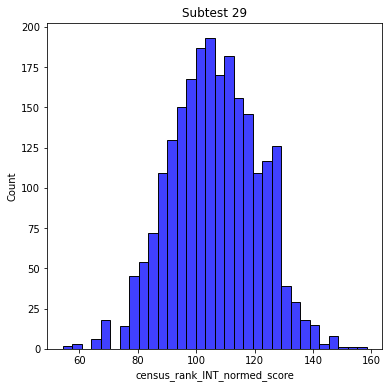

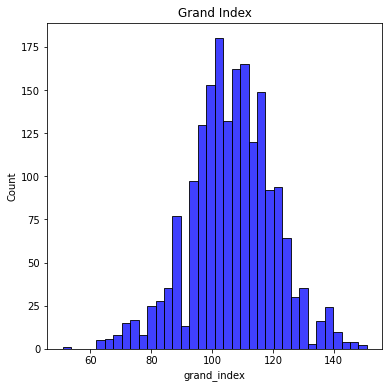

Mean Grand Index: 106.51891063021091
Std. dev. of Grand Index: 13.968754068310265


In [13]:
# Lookup normalized scores using the 'census_rank_INT' method (see paper for details)
# Note that by default, scores normalized using the 'rank_INT' method are included in the dataset by default (not shown)
# Also plot the grand index
norm_method = 'census_rank_INT'
score_col = f'{norm_method}_normed_score'
subtests_to_plot = [29]

ncpt.lookup_normed_scores(norm_method)
print('---------------------------')

# Plot the normalized score distributions
subtests = ncpt.df['specific_subtest_id'].unique()
for sub in subtests_to_plot:
    sub_df = ncpt.df.query('specific_subtest_id == @sub')
    print(f'Subtest {sub}')
    print(f"Mean of normed scores: {sub_df[score_col].mean()}")
    print(f"Std. dev. of normed scores: {sub_df[score_col].std()}")
    fig, axes = plt.subplots(1, 1, figsize=(6, 6))
    sns.histplot(sub_df[score_col], color='b', kde=False, ax=axes)
    axes.set_title(f'Subtest {sub}')
    plt.show()
                 
# Plot the distribution of the Grand Index
GI_df = ncpt.df.drop_duplicates(subset=['test_run_id'])
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
sns.histplot(GI_df['grand_index'], color='b', kde=False, ax=axes)
axes.set_title('Grand Index')
plt.show()

# Stats
print(f"Mean Grand Index: {GI_df['grand_index'].mean()}")
print(f"Std. dev. of Grand Index: {GI_df['grand_index'].std()}")

### Plot the Grand Index vs. age
- Red line is best linear fit

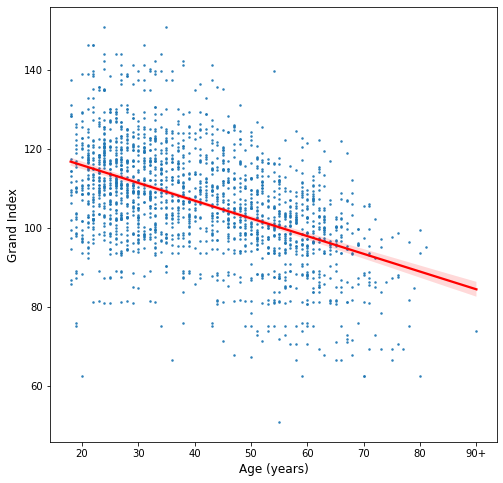

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
fontsize = 12
sns.regplot(x='age', y='grand_index', data=GI_df, ax=axes, marker='.', 
            scatter_kws={'s': 10}, line_kws={'color': 'r'})
axes.set_xlabel('Age (years)', fontsize=fontsize)
axes.set_ylabel('Grand Index', fontsize=fontsize)
axes.set_xticks([20, 30, 40, 50, 60, 70, 80, 90])
axes.set_xticklabels(['20', '30', '40', '50', '60', '70', '80', '90+'])
plt.show()

## 3) Miscellaneous

In [15]:
# Display the meaning of the numeric education levels
ncpt.get_education_info()

# Filter out participants who did not complete the test battery
filt_df, exclude_df = ncpt.filter_by_completeness()
print(f'Filtered out {len(exclude_df)} subtests \n')

Key for education levels
------------------------
1: Some high school
2: High school diploma / GED
3: Some college
4: College degree
5: Professional degree
6: Master's degree
7: Ph.D.
8: Associate's degree
99: Other

Filtered out 2745 subtests 

